In [1]:
import sys

sys.path.append('../../')

import numpy as np
import scipy
from scipy.linalg import sqrtm
import scipy.sparse as sp
from scipy.sparse import coo_matrix, csr_matrix
import matplotlib.pyplot as plt
import networkx as nx
from tqdm import tqdm_notebook as tqdm
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from IPython.display import clear_output

from lanczos.lanczos import lanczos_algorithm, process_adjacency_matrix
from pygcn.pygcn.utils import encode_onehot, normalize, accuracy
from data.loader import load_data
from nn.layers import SpectralConv
from pygcn.pygcn.layers import GraphConvolution

%load_ext autoreload
%autoreload 2
%matplotlib inline
plt.rcParams['figure.figsize'] = (7, 5)

# Data load
Datasets: CORA/Pubmed/CiteSeer

In [2]:
from gcn.gcn.utils import load_data as gcn_load_data
adj, features, labels, idx_train, idx_val, idx_test = load_data('cora',\
                                                                data_dir = '../../data/datasets/') # /cora/citeseer
A = np.array(adj.todense())

## Data processing

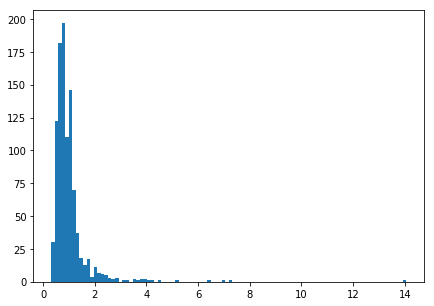

In [3]:
plt.hist(A.sum(0)[:1000], bins=100)
plt.show()

In [4]:
k=20
S, V, R = process_adjacency_matrix(A, k) #need only this one
S, Q, T = process_adjacency_matrix(A, k, ritz=False)

100%|██████████| 20/20 [00:00<00:00, 416.67it/s]


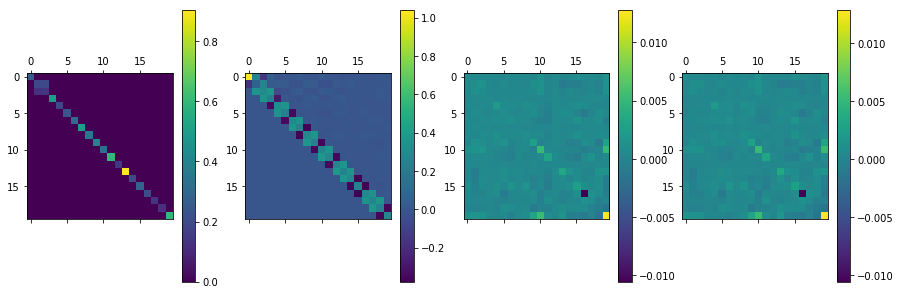

In [5]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15, 5))
m1 = ax1.matshow(S[:20,:20])
m2 = ax2.matshow(T[:20,:20])
m3 = ax3.matshow((Q@T@Q.T)[:20,:20])
m4 = ax4.matshow((V@R@V.T)[:20,:20])
f.colorbar(m1, ax=ax1)
f.colorbar(m2, ax=ax2)
f.colorbar(m3, ax=ax3)
f.colorbar(m4, ax=ax4)

## Networks

In [14]:
class GCN(nn.Module):
    '''
    Graph convolution network
    '''
    def __init__(self, feat_dim, num_classes, inner_dim = 1024):
        super(GCN, self).__init__()
        self.conv1 = GraphConvolution(feat_dim, inner_dim)
        self.conv2 = GraphConvolution(inner_dim, num_classes)
                                      
    def forward(self, adj, X, S, V, R):
        Z = self.conv1(X, adj)
        Z = self.conv2(Z, adj)       
        
        return F.log_softmax(Z)



class LanczosNet(nn.Module):
    '''
    Spectral convolutions + MLP
    '''
    def __init__(self, k, feat_dim, num_classes, short_scales, long_scales, out_features = 512, inner_dim = 256):
        super(LanczosNet, self).__init__()
        self.spectral_conv1 = SpectralConv(feat_dim, out_features, k, short_scales, long_scales, mlp_layers_number=1)
        self.spectral_conv2 = SpectralConv(out_features, inner_dim, k, short_scales, long_scales, mlp_layers_number=1)
        self.mlp = nn.Sequential(nn.Linear(inner_dim, num_classes),
                                nn.ReLU())
        self.bn = nn.BatchNorm1d(out_features)
        self.dropout = nn.Dropout(0.05)
                                      
    def forward(self, adj, X, S, V, R):
        Z = self.spectral_conv1(X, S, V, R)
#         Z = self.dropout(Z)

        Z = self.spectral_conv2(Z, S, V, R)
#         Z = self.bn(self.dropout(Z))
        Z = self.mlp(Z)        
        
        return F.log_softmax(Z)



class LanczosConvNet(nn.Module):
    '''
    Spectral convolutions + graph convolutions
    '''
    def __init__(self, k, feat_dim, num_classes, short_scales, long_scales, out_features = 1024, inner_dim = 512):
        super(LanczosConvNet, self).__init__()
        self.spectral_conv = SpectralConv(feat_dim, out_features, k, short_scales, long_scales, mlp_layers_number=1)
        self.bn = nn.BatchNorm1d(out_features)
        self.dropout = nn.Dropout(0.05)
        self.conv1 = GraphConvolution(out_features+feat_dim, inner_dim)
        self.conv2 = GraphConvolution(inner_dim, num_classes)
                                      
    def forward(self, adj, X, S, V, R):
        Z = self.spectral_conv(X, S, V, R)
        Z = self.bn(self.dropout(Z))
        Z = torch.cat((Z,X), 1)
        Z = self.conv1(Z, adj)
        Z = self.conv2(Z, adj)        
        
        return F.log_softmax(Z)

In [7]:
n = adj.shape[0]
feat_dim = features.shape[-1]
short_scales = [1,5,7]
long_scales = [10,20,30]
num_classes = len(np.unique(labels))

In [8]:
A = torch.Tensor(A).cuda()
X = features.cuda()
S = torch.Tensor(S).cuda()
V = torch.Tensor(V).cuda()
w = torch.Tensor(np.diag(R)).cuda()
labels = torch.LongTensor(labels).cuda()

In [9]:
loss_train_vals = []
loss_val_vals = []
acc_train_vals = []
acc_val_vals = []


def train(epoch, loss_train_vals, loss_val_vals, acc_train_vals, acc_val_vals, eval_epoch=3):
    model.train()
    optimizer.zero_grad()
    output = model(A, X, S, V, w)
    loss_train = F.nll_loss(output[idx_train], labels[idx_train])
    acc_train = accuracy(output[idx_train], labels[idx_train])
    loss_train.backward()
    optimizer.step()

    model.eval()
    output = model(A, X, S, V, w)

    loss_val = F.nll_loss(output[idx_val], labels[idx_val])
    acc_val = accuracy(output[idx_val], labels[idx_val])
    
    loss_train_vals.append(loss_train.item())
    loss_val_vals.append(loss_val.item())
    acc_train_vals.append(acc_train.item())
    acc_val_vals.append(acc_val.item())
    
    if epoch > 0 and epoch%eval_epoch == 0:
        
        print('Epoch: {:04d}'.format(epoch+1),
              'loss_train: {:.4f}'.format(loss_train_vals[-1]),
              'acc_train: {:.4f}'.format(acc_train_vals[-1]),
              'loss_val: {:.4f}'.format(loss_val_vals[-1]),
              'acc_val: {:.4f}'.format(acc_val_vals[-1]))


def test():
    model.eval()
    output = model(A, X, S, V, w)
    loss_test = F.nll_loss(output[idx_test], labels[idx_test])
    acc_test = accuracy(output[idx_test], labels[idx_test])
    print("Test set results:",
          "loss= {:.4f}".format(loss_test.item()),
          "accuracy= {:.4f}".format(acc_test.item()))
    
def run_experiment(experiment_name = '', epochs=80):
    loss_train_vals = []
    loss_val_vals = []
    acc_train_vals = []
    acc_val_vals = []
    for epoch in tqdm(range(epochs)):
        train(epoch, loss_train_vals, loss_val_vals, acc_train_vals, acc_val_vals)
    print(f'\nmin val loss: \t{loss_val_vals[np.argmin(acc_val_vals)]}')
    print(f'max val accuracy: \t{max(acc_val_vals)}')
    test()

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    ax1.plot(loss_train_vals, label='train')
    ax1.plot(loss_val_vals, label='test')
    ax1.set_title(f'{experiment_name}, loss')
    ax1.legend()

    ax2.plot(acc_train_vals, label='train')
    ax2.plot(acc_val_vals, label='test')
    ax2.set_title(f'{experiment_name}, accuracy')
    ax2.legend()

    plt.show()

    

## Graph convolutions

A Jupyter Widget

/opt/anaconda/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  


Epoch: 0004 loss_train: 0.6951 acc_train: 0.9643 loss_val: 1.0364 acc_val: 0.7740
Epoch: 0007 loss_train: 0.2432 acc_train: 0.9857 loss_val: 0.8067 acc_val: 0.7740
Epoch: 0010 loss_train: 0.1030 acc_train: 0.9929 loss_val: 0.7503 acc_val: 0.7720
Epoch: 0013 loss_train: 0.0495 acc_train: 0.9929 loss_val: 0.7521 acc_val: 0.7640
Epoch: 0016 loss_train: 0.0271 acc_train: 1.0000 loss_val: 0.7785 acc_val: 0.7660
Epoch: 0019 loss_train: 0.0166 acc_train: 1.0000 loss_val: 0.8105 acc_val: 0.7620
Epoch: 0022 loss_train: 0.0111 acc_train: 1.0000 loss_val: 0.8376 acc_val: 0.7580
Epoch: 0025 loss_train: 0.0081 acc_train: 1.0000 loss_val: 0.8562 acc_val: 0.7560
Epoch: 0028 loss_train: 0.0061 acc_train: 1.0000 loss_val: 0.8676 acc_val: 0.7580
Epoch: 0031 loss_train: 0.0048 acc_train: 1.0000 loss_val: 0.8746 acc_val: 0.7580
Epoch: 0034 loss_train: 0.0040 acc_train: 1.0000 loss_val: 0.8800 acc_val: 0.7580
Epoch: 0037 loss_train: 0.0034 acc_train: 1.0000 loss_val: 0.8852 acc_val: 0.7600
Epoch: 0040 loss

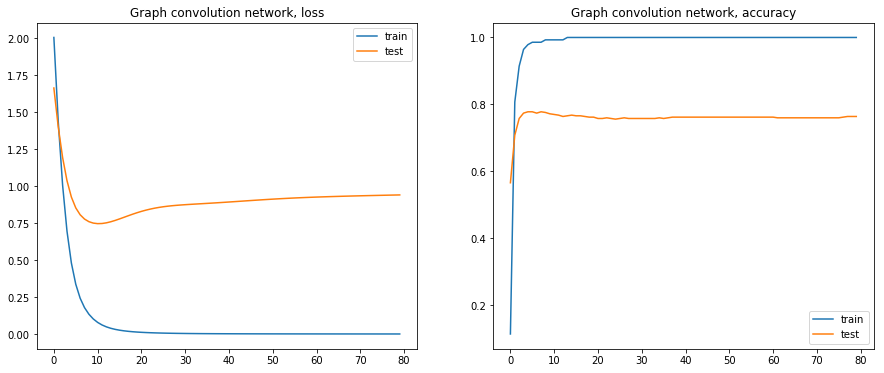

In [10]:
lr = 1e-3
inner_dim = 512
model = GCN(feat_dim,  num_classes, inner_dim).cuda()
optimizer = optim.Adam(model.parameters(), lr=lr)

run_experiment('Graph convolution network')

## Spectral convolutions + graph convolutions

A Jupyter Widget

/opt/anaconda/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:62: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch: 0004 loss_train: 0.0744 acc_train: 0.9714 loss_val: 1.2748 acc_val: 0.5380
Epoch: 0007 loss_train: 0.0185 acc_train: 0.9929 loss_val: 1.0233 acc_val: 0.6580
Epoch: 0010 loss_train: 0.0037 acc_train: 1.0000 loss_val: 0.9995 acc_val: 0.6920
Epoch: 0013 loss_train: 0.0002 acc_train: 1.0000 loss_val: 1.0570 acc_val: 0.7040
Epoch: 0016 loss_train: 0.0007 acc_train: 1.0000 loss_val: 1.1476 acc_val: 0.7240
Epoch: 0019 loss_train: 0.0019 acc_train: 1.0000 loss_val: 1.2611 acc_val: 0.7300
Epoch: 0022 loss_train: 0.0004 acc_train: 1.0000 loss_val: 1.3914 acc_val: 0.7420
Epoch: 0025 loss_train: 0.0001 acc_train: 1.0000 loss_val: 1.5381 acc_val: 0.7480
Epoch: 0028 loss_train: 0.0001 acc_train: 1.0000 loss_val: 1.7009 acc_val: 0.7520
Epoch: 0031 loss_train: 0.0001 acc_train: 1.0000 loss_val: 1.8782 acc_val: 0.7540
Epoch: 0034 loss_train: 0.0001 acc_train: 1.0000 loss_val: 2.0639 acc_val: 0.7540
Epoch: 0037 loss_train: 0.0001 acc_train: 1.0000 loss_val: 2.2506 acc_val: 0.7520
Epoch: 0040 loss

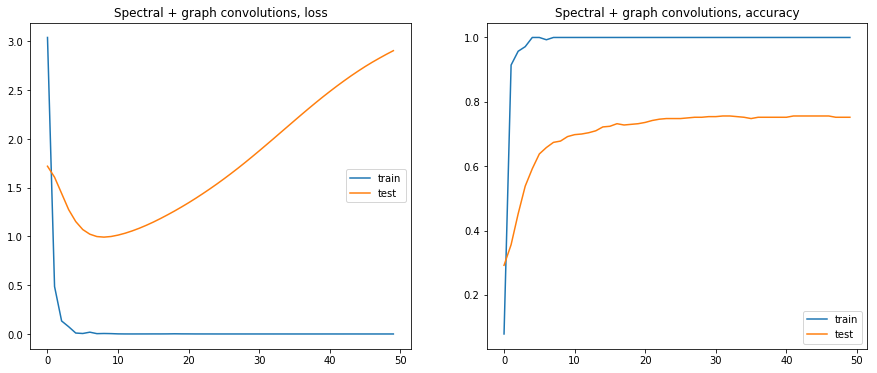

In [22]:
lr = 1e-3
model = LanczosConvNet(k, feat_dim,  num_classes, short_scales, long_scales).cuda()
optimizer = optim.Adam(model.parameters(), lr=lr)

run_experiment('Spectral + graph convolutions',50)

## Spectral convolutions + MLP

A Jupyter Widget

/opt/anaconda/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:39: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch: 0004 loss_train: 1.6496 acc_train: 0.5071 loss_val: 1.7828 acc_val: 0.2900
Epoch: 0007 loss_train: 1.1230 acc_train: 0.6500 loss_val: 1.5179 acc_val: 0.5140
Epoch: 0010 loss_train: 0.7631 acc_train: 0.8000 loss_val: 1.2970 acc_val: 0.6280
Epoch: 0013 loss_train: 0.5361 acc_train: 0.8429 loss_val: 1.3032 acc_val: 0.6200
Epoch: 0016 loss_train: 0.2729 acc_train: 0.9500 loss_val: 1.1968 acc_val: 0.6940
Epoch: 0019 loss_train: 0.1007 acc_train: 0.9857 loss_val: 1.4294 acc_val: 0.6520
Epoch: 0022 loss_train: 0.0416 acc_train: 0.9929 loss_val: 1.3996 acc_val: 0.7340
Epoch: 0025 loss_train: 0.0227 acc_train: 0.9929 loss_val: 1.4925 acc_val: 0.7480
Epoch: 0028 loss_train: 0.0174 acc_train: 0.9929 loss_val: 1.6590 acc_val: 0.7460
Epoch: 0031 loss_train: 0.0092 acc_train: 1.0000 loss_val: 1.9078 acc_val: 0.7440
Epoch: 0034 loss_train: 0.0060 acc_train: 1.0000 loss_val: 2.1412 acc_val: 0.7380
Epoch: 0037 loss_train: 0.0044 acc_train: 1.0000 loss_val: 2.2795 acc_val: 0.7360
Epoch: 0040 loss

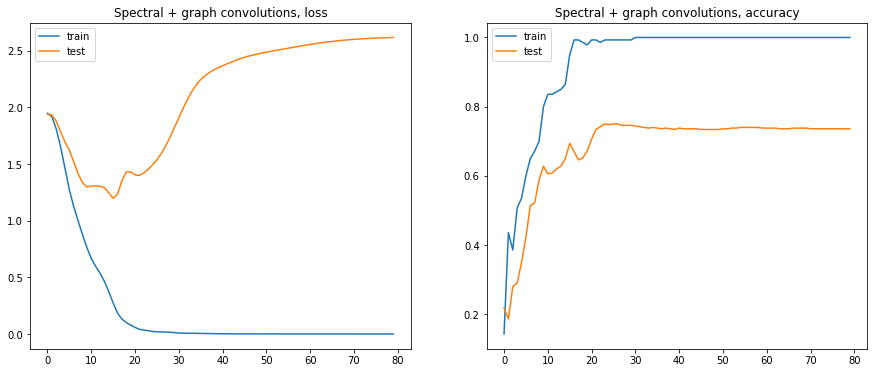

In [23]:
lr = 1e-3
model = LanczosNet(k, feat_dim,  num_classes, short_scales, long_scales).cuda()
optimizer = optim.Adam(model.parameters(), lr=lr)

run_experiment('Spectral + graph convolutions')